In [7]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

def compute_cytoscape_metrics(edges_list, directed=False):
    """
    Compute Cytoscape-style network metrics in Python

    Parameters:
    - edges_list: List of edges [(source, target), ...]
    - directed: Whether the network is directed

    Returns:
    - DataFrame with all centrality metrics
    """

    # Create graph (directed or undirected)
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()

    # Add edges to the network
    G.add_edges_from(edges_list)

    # Compute basic degree (same as Cytoscape)
    degree_dict = dict(G.degree())

    # Compute centrality measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)

    # Create comprehensive results DataFrame
    results = pd.DataFrame({
        'node': list(degree_dict.keys()),
        'degree': list(degree_dict.values()),
        'degree_centrality': [degree_centrality[node] for node in degree_dict.keys()],
        'betweenness_centrality': [betweenness_centrality[node] for node in degree_dict.keys()],
        'closeness_centrality': [closeness_centrality[node] for node in degree_dict.keys()]
    })

    return results, G

# Example with compound-target-disease data
edges = [
    ('Compound_A', 'Target_1'), ('Compound_A', 'Target_2'),
    ('Compound_B', 'Target_1'), ('Compound_C', 'Target_3'),
    ('Target_1', 'Disease_X'), ('Target_2', 'Disease_Y'),
    ('Target_3', 'Disease_X'), ('Target_1', 'Target_2')  # protein-protein interaction
]

# Compute metrics
results, network = compute_cytoscape_metrics(edges, directed=False)

print("Network Centrality Metrics:")
print("=" * 50)
print(results.sort_values('betweenness_centrality', ascending=False))

Network Centrality Metrics:
         node  degree  degree_centrality  betweenness_centrality  \
1    Target_1       4           0.571429                0.714286   
6   Disease_X       2           0.285714                0.476190   
5    Target_3       2           0.285714                0.285714   
2    Target_2       3           0.428571                0.285714   
3  Compound_B       1           0.142857                0.000000   
0  Compound_A       2           0.285714                0.000000   
4  Compound_C       1           0.142857                0.000000   
7   Disease_Y       1           0.142857                0.000000   

   closeness_centrality  
1              0.636364  
6              0.538462  
5              0.411765  
2              0.500000  
3              0.411765  
0              0.466667  
4              0.304348  
7              0.350000  


In [4]:
def comprehensive_network_analysis(G):
    """
    Perform comprehensive network analysis similar to Cytoscape NetworkAnalyzer
    """

    # Basic network properties
    network_stats = {
        'number_of_nodes': nx.number_of_nodes(G),
        'number_of_edges': nx.number_of_edges(G),
        'density': nx.density(G),
        'average_degree': sum(dict(G.degree()).values()) / nx.number_of_nodes(G),
        'diameter': nx.diameter(G) if nx.is_connected(G) else 'Disconnected',
        'average_clustering': nx.average_clustering(G)
    }

    # Additional centrality measures
    metrics_df = pd.DataFrame({
        'node': list(G.nodes()),
        'degree': [d for n, d in G.degree()],
        'in_degree': [d for n, d in G.in_degree()] if nx.is_directed(G) else [0]*len(G.nodes()),
        'out_degree': [d for n, d in G.out_degree()] if nx.is_directed(G) else [0]*len(G.nodes()),
        'betweenness': list(nx.betweenness_centrality(G).values()),
        'closeness': list(nx.closeness_centrality(G).values()),
        'eigenvector': list(nx.eigenvector_centrality(G, max_iter=1000).values()),
        'pagerank': list(nx.pagerank(G).values())
    })

    return metrics_df, network_stats

# Run comprehensive analysis
metrics_df, stats = comprehensive_network_analysis(network)

print("\nNetwork Statistics:")
print("=" * 30)
for key, value in stats.items():
    print(f"{key}: {value}")

print(f"\nTop Nodes by Betweenness Centrality:")
print("=" * 40)
print(metrics_df.nlargest(5, 'betweenness')[['node', 'betweenness', 'degree', 'closeness']])


Network Statistics:
number_of_nodes: 8
number_of_edges: 8
density: 0.2857142857142857
average_degree: 2.0
diameter: 5
average_clustering: 0.1875

Top Nodes by Betweenness Centrality:
         node  betweenness  degree  closeness
1    Target_1     0.714286       4   0.636364
6   Disease_X     0.476190       2   0.538462
2    Target_2     0.285714       3   0.500000
5    Target_3     0.285714       2   0.411765
0  Compound_A     0.000000       2   0.466667


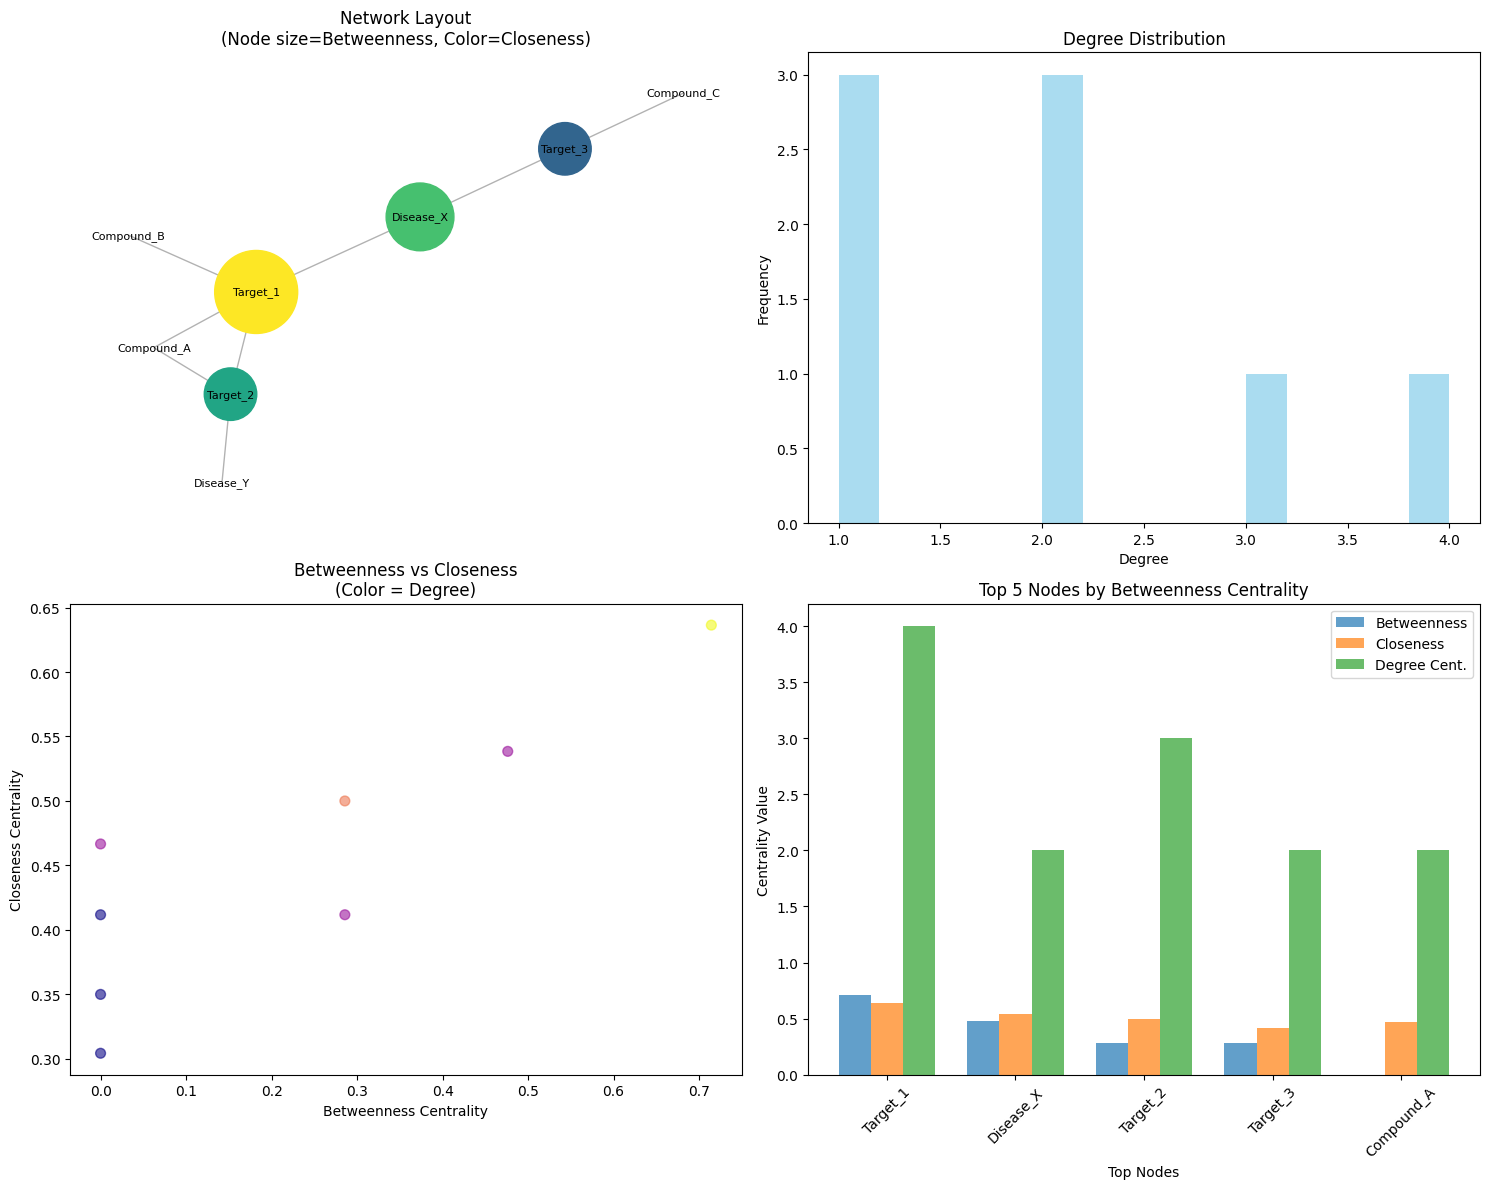

In [8]:
def plot_network_metrics(G, metrics_df):
    """
    Create Cytoscape-like visualizations of network metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Network layout with node size = betweenness
    pos = nx.spring_layout(G, seed=42)
    node_sizes = [v * 5000 for v in metrics_df['betweenness']]

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                          node_color=metrics_df['closeness'],
                          cmap='viridis', ax=axes[0,0])
    nx.draw_networkx_edges(G, pos, alpha=0.3, ax=axes[0,0])
    nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[0,0])
    axes[0,0].set_title('Network Layout\n(Node size=Betweenness, Color=Closeness)')
    axes[0,0].axis('off')

    # Plot 2: Degree distribution
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    axes[0,1].hist(degree_sequence, bins=15, alpha=0.7, color='skyblue')
    axes[0,1].set_xlabel('Degree')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Degree Distribution')

    # Plot 3: Betweenness vs Closeness
    axes[1,0].scatter(metrics_df['betweenness'], metrics_df['closeness'],
                     alpha=0.6, s=50, c=metrics_df['degree'], cmap='plasma')
    axes[1,0].set_xlabel('Betweenness Centrality')
    axes[1,0].set_ylabel('Closeness Centrality')
    axes[1,0].set_title('Betweenness vs Closeness\n(Color = Degree)')

    # Plot 4: Top central nodes
    top_nodes = metrics_df.nlargest(5, 'betweenness')
    x = range(len(top_nodes))
    width = 0.25

    axes[1,1].bar([i - width for i in x], top_nodes['betweenness'],
                 width, label='Betweenness', alpha=0.7)
    axes[1,1].bar(x, top_nodes['closeness'], width, label='Closeness', alpha=0.7)
    axes[1,1].bar([i + width for i in x], top_nodes['degree'],
                 width, label='Degree Cent.', alpha=0.7)

    axes[1,1].set_xlabel('Top Nodes')
    axes[1,1].set_ylabel('Centrality Value')
    axes[1,1].set_title('Top 5 Nodes by Betweenness Centrality')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(top_nodes['node'], rotation=45)
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

# Generate plots
plot_network_metrics(network, metrics_df)

In [9]:
def import_cytoscape_data(node_file, edge_file):
    """
    Import data exported from Cytoscape
    """
    # Read files (export from Cytoscape as CSV)
    nodes_df = pd.read_csv(node_file)
    edges_df = pd.read_csv(edge_file)

    # Create network from edges
    G = nx.from_pandas_edgelist(edges_df,
                               source='source_column',
                               target='target_column',
                               edge_attr=True)

    return G, nodes_df, edges_df

# Example usage:
# G, nodes_df, edges_df = import_cytoscape_data('nodes.csv', 'edges.csv')
# results, stats = comprehensive_network_analysis(G)

In [10]:
def interpret_pharmacology_results(metrics_df):
    """
    Provide biological interpretation of network metrics
    """
    print("BIOLOGICAL INTERPRETATION:")
    print("=" * 40)

    # Identify key nodes
    hub_compound = metrics_df.nlargest(1, 'degree')['node'].iloc[0]
    key_target = metrics_df.nlargest(1, 'betweenness')['node'].iloc[0]
    central_disease = metrics_df.nlargest(1, 'closeness')['node'].iloc[0]

    print(f"🔬 Hub Compound: {hub_compound} (high degree - interacts with multiple targets)")
    print(f"🎯 Key Target: {key_target} (high betweenness - connects different network regions)")
    print(f"📊 Central Disease: {central_disease} (high closeness - efficiently connected to other nodes)")

    # Additional insights
    high_degree_nodes = metrics_df[metrics_df['degree'] > metrics_df['degree'].mean()]
    print(f"\nNodes with above-average degree: {len(high_degree_nodes)}")
    print("These might be polypharmacological compounds or promiscuous targets")

# Run interpretation
interpret_pharmacology_results(metrics_df)

BIOLOGICAL INTERPRETATION:
🔬 Hub Compound: Target_1 (high degree - interacts with multiple targets)
🎯 Key Target: Target_1 (high betweenness - connects different network regions)
📊 Central Disease: Target_1 (high closeness - efficiently connected to other nodes)

Nodes with above-average degree: 2
These might be polypharmacological compounds or promiscuous targets


In [11]:
# One-liner to get Cytoscape-like metrics
edges = [('C1','T1'), ('C1','T2'), ('T1','D1')]  # Your edges here
G = nx.Graph(); G.add_edges_from(edges)
metrics = pd.DataFrame({
    'degree': dict(G.degree()),
    'betweenness': nx.betweenness_centrality(G),
    'closeness': nx.closeness_centrality(G)
})
print(metrics)

    degree  betweenness  closeness
C1       2     0.666667       0.75
T1       2     0.666667       0.75
T2       1     0.000000       0.50
D1       1     0.000000       0.50
